In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import copy
import pickle
from torchvision import transforms

from get3d_utils import constructGenerator, eval_get3d_angles, generate_rotate_camera_list
from latent_mapper import LatentMapper, LayerTransform

In [4]:
def preprocess_rgb(array):
    img = array
    img = transforms.Normalize(mean=[-1.0, -1.0, -1.0], std=[2.0, 2.0, 2.0])(img)
    img = img.transpose(1, 3)
    img = img.transpose(1, 2)
    img = img.clip(0., 1.)
    return img.cpu().numpy()

In [5]:

with open('test.pickle', 'rb') as f:
        generator_args = pickle.load(f)

G_ema = constructGenerator(**generator_args)

constructing
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
==> resume from pretrained path pretrained_model/shapenet_car.pt


In [6]:
torch.manual_seed(0)

In [7]:
vehicle_type = 'Sedan'

loss_types = ['directional']

mappers = {}

for loss_type in loss_types:
    mappers[loss_type] = torch.load(f'latent_mapper_saved/{vehicle_type}_{loss_type}_mapper.pt')

In [8]:
n_samples = 10

z_geo = torch.randn(n_samples, 512).to('cuda')
z_tex = torch.randn(n_samples, 512).to('cuda')

with torch.no_grad():
    ws_geo = G_ema.mapping_geo(z_geo, c=torch.ones(1, device='cuda'), truncation_psi=0.7, update_emas=False)
    ws_tex = G_ema.mapping(z_tex, c=torch.ones(1, device='cuda'), truncation_psi=0.7, update_emas=False)

In [9]:
with torch.no_grad():
    cameras = generate_rotate_camera_list()
    cameras = [cameras[4]]
    imgs = []
    for i, _ in enumerate(ws_geo):
        img_original = eval_get3d_angles(G_ema, ws_geo[i].unsqueeze(0), ws_tex[i].unsqueeze(0), cameras=cameras, intermediate_space=True).cpu()
        imgs.append(img_original)
        for mapper in loss_types:
            geo_edited, tex_edited = mappers[mapper](ws_geo[i].unsqueeze(0), ws_tex[i].unsqueeze(0))
            img_edited = eval_get3d_angles(G_ema, geo_edited, tex_edited, cameras=cameras, intermediate_space=True).cpu()
            imgs.append(img_edited)
            torch.cuda.empty_cache()
imgs = torch.cat(imgs)

/home/windows-ssh/git/GET3D/get3d_utils.py:351: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  camera_theta = torch.range(0, n_camera - 1, device='cuda').unsqueeze(dim=-1) / n_camera * math.pi * 2.0


In [10]:

with torch.no_grad():
    preprocessed_imgs = preprocess_rgb(imgs)

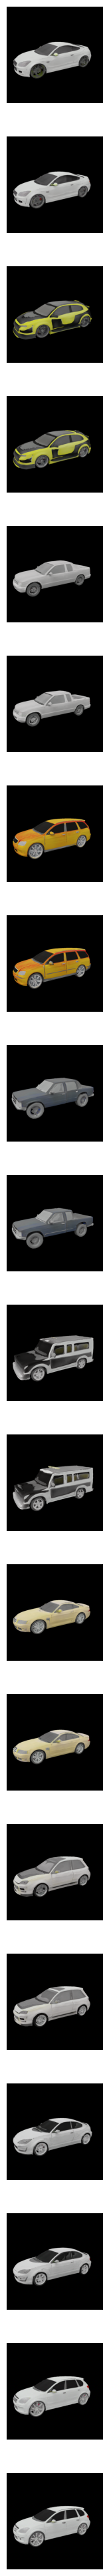

In [11]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(12., 50.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(n_samples * (len(loss_types) + 1), len(cameras)),
                 axes_pad=(0.1, 0.5),
                 )

for i, (ax, im) in enumerate(zip(grid, preprocessed_imgs)):
    ax.axis('off')
    #ax.set_title(f'{i}')
    ax.imshow(im)

In [1]:

import pickle
import matplotlib.pyplot as plt
import numpy as np
with open('latent_mapper_Sedan_directional_metrics.pickle', 'rb') as f:
    loss_dict = pickle.load(f)

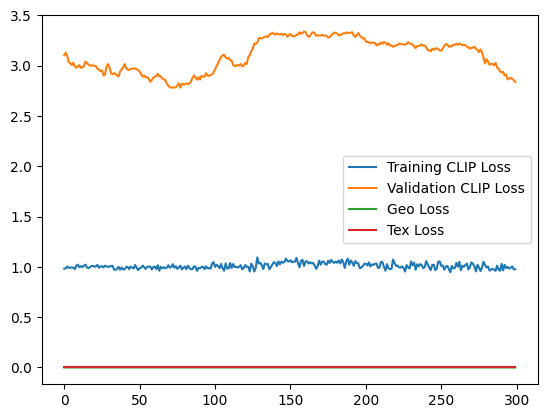

In [2]:
fig, ax = plt.subplots(1, 1)
for key in loss_dict:
    ax.plot(np.array(loss_dict[key]), label=key)
ax.legend()
plt.show()

In [ ]:
with open('image_sample_2.pkl', 'wb') as f:
    pickle.dump(imgs, f)

In [12]:
with open('image_sample.pkl', 'wb') as f:
    pickle.dump(imgs, f)

In [27]:
with open('grads_latent_mapper.pickle', 'rb') as f:
    grads = pickle.load(f)

In [28]:
grads_ = [[p for p in g if not (p is None)] for g in grads]

In [14]:
grads_ = np.array(grads_)

In [31]:
len(grads_)

160

In [17]:
np.histogram(grads_[0])

(array([7, 1, 1, 0, 1, 0, 0, 1, 0, 1]),
 array([2.44330037e-02, 3.69903591e+00, 7.37363881e+00, 1.10482417e+01,
        1.47228446e+01, 1.83974475e+01, 2.20720504e+01, 2.57466533e+01,
        2.94212562e+01, 3.30958591e+01, 3.67704620e+01]))

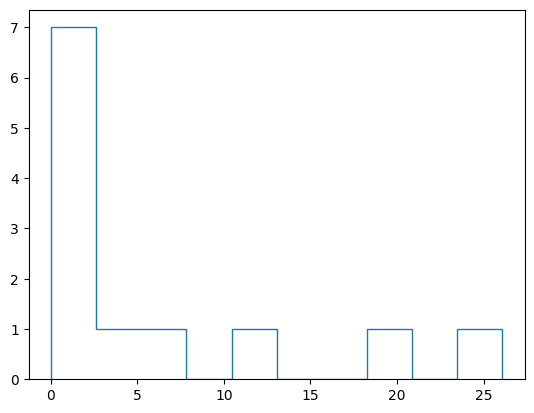

In [19]:
counts, bins = np.histogram(grads_[1])
plt.stairs(counts, bins)